<a href="https://colab.research.google.com/github/Spleen0291/Emotion_Detection/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction
<hr>

Humans communicate using facial expressions as well as other body language and verbal cues. Researchers are using deep learning approaches in artificial intelligence research as a way to help make decisions. They need to study people in order to predict how they'll respond or know what they're feeling. This study proposes the development of a system that predicts and classifies facial emotions by using the Convolution Neural Network algorithm, among other features.

Data preprocessing, facial feature extraction, and facial emotion classification are the three key steps in this notebook. Facial expressions were predicted with 62.66% accuracy using the Convolutional Neural Network (CNN). This algorithm was evaluated on a database from [FER2013](https://https://www.kaggle.com/datasets/deadskull7/fer2013) database, which has **35887 48x48** grayscale images representing each of the emotions.

<br>

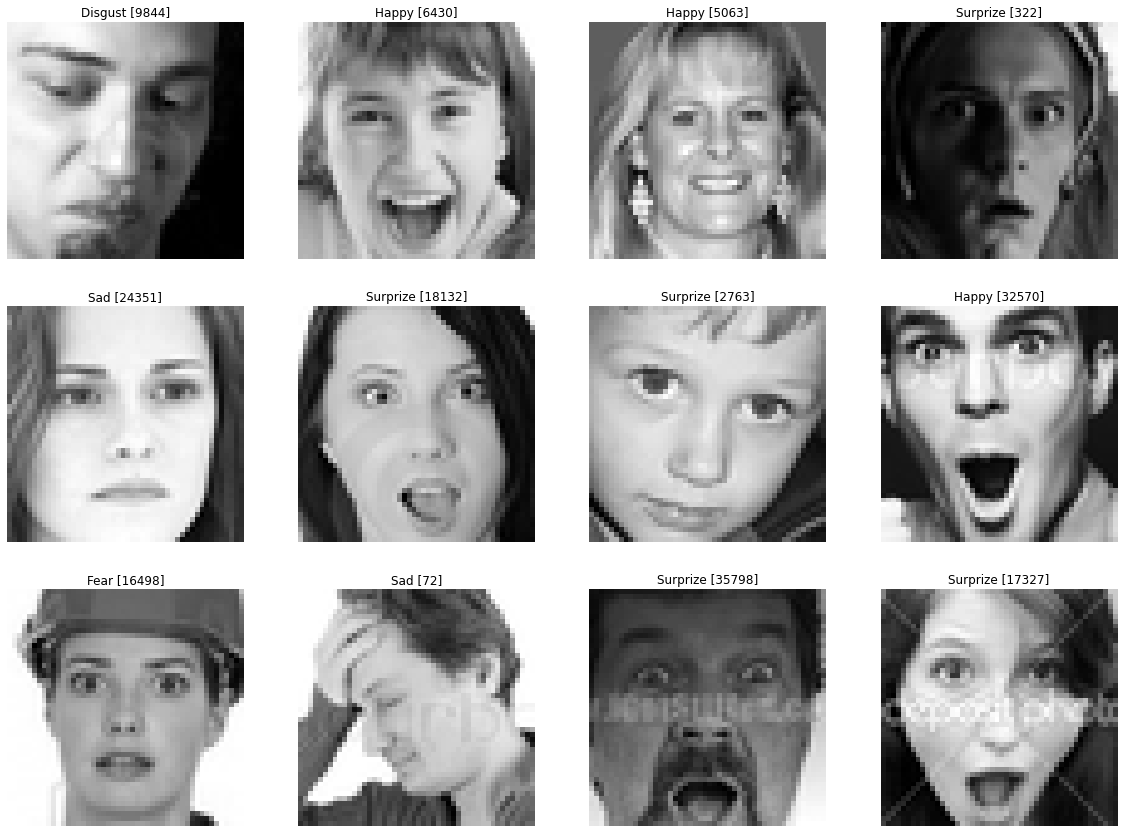

##Here we are also going to use OpenCV for the webcam and model deployement.

#Setting up kaggle api for getting the datset
<hr>

####For that you can go to kaggle.com-> your profile-> Account-> Create New API Token
Then upload the kaggle.json file in google collab and then run the below commands

In [136]:
! pip install kaggle
! mkdir ~/.kaggle #creating a hidden directory
! cp kaggle.json ~/.kaggle/ #pasting the kaggle api token to above dir
! chmod 600 ~/.kaggle/kaggle.json ## chaging the mode for the file

mkdir: cannot create directory ‘/root/.kaggle’: File exists


**Put the name of the dataset that you want to use and then unzip the dataset**

In [137]:
! kaggle datasets download deadskull7/fer2013 # downloading the datset

Dataset URL: https://www.kaggle.com/datasets/deadskull7/fer2013
License(s): CC0-1.0
  0% 0.00/96.6M [00:00<?, ?B/s]
100% 96.6M/96.6M [00:00<00:00, 1.40GB/s]


In [138]:
! unzip /content/fer2013.zip #unzip the downloaded dataset

Archive:  /content/fer2013.zip
  inflating: fer2013.csv             


#Importing necesaary files
<hr>



In [139]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D,MaxPool2D,ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import vgg16
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

#for model deployement
import os
import cv2
import numpy as np
from tensorflow.keras.models import model_from_json
from tensorflow.keras.utils import img_to_array

In [140]:
df = pd.read_csv('./fer2013.csv') #read dataset

df.head(5),df.shape  #first five rows and count of rows and columns

(   emotion                                             pixels     Usage
 0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
 1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
 2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
 3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
 4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training,
 (35887, 3))

#Exploraotry Data Analysis
<hr>



In [141]:
print("Null values present in the file:",df.isna().sum().sum())
print("Basic information about the dataframe:")
df.info()

df.describe()

Null values present in the file: 0
Basic information about the dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


,emotion
count,35887.000000
mean,3.323265
std,1.873819
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


In [143]:
emotions = { #list of available emotions in the dataset
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprize",
    6:"Neutral"
}

##No of images present in dataset corresponding to each emotion

In [144]:
count_emotions = (df.groupby(df['emotion'])['pixels'].count()).to_frame()
count_emotions['emotion name'] = [emotions[k] for k in emotions.keys()]
count_emotions

,pixels,emotion name
emotion,,
0,4953,Angry
1,547,Disgust
2,5121,Fear
3,8989,Happy
4,6077,Sad
5,4002,Surprize
6,6198,Neutral


##No of images present in dataset corresponding to training testing and validation part

In [145]:
count_usage = (df.groupby(df['Usage'])['pixels'].count()).to_frame()
count_usage

,pixels
Usage,
PrivateTest,3589
PublicTest,3589
Training,28709


##Visualizing images from the dataset

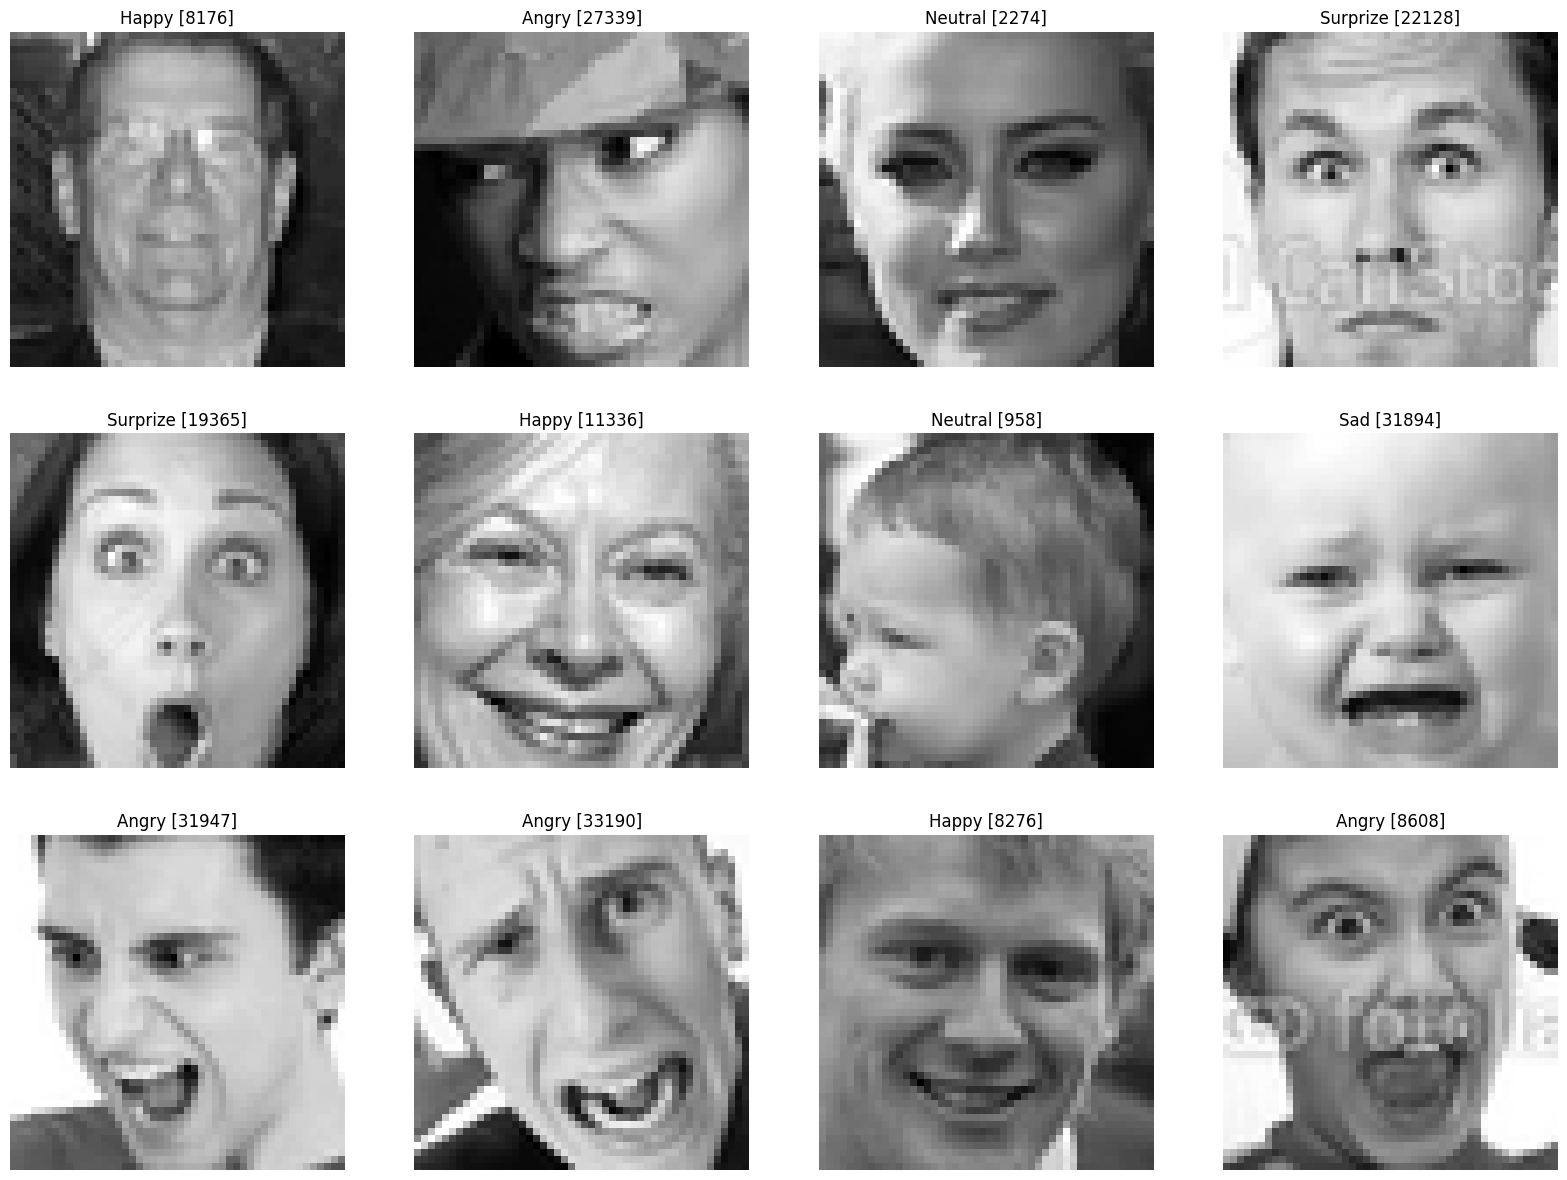

In [146]:
# from PIL import Image
# pixels = df['pixels'][0]
# b = bytes(int(p) for p in pixels.split())
# i = Image.frombuffer('L',(48,48),b)
# di.save('a.png')
def visualize_images(n_img=4):
    indices = np.random.randint(0,df.shape[0],size=n_img)
#     print(indices)
    plt.figure(figsize=(20,20))
    for i,l in zip(indices,range(0,len(indices))):
        image_ar = np.array([i for i in  df['pixels'][i].split()] , dtype='float')
        pixels = np.reshape(image_ar,(48,48))
        ax = plt.subplot(4,4,l+1)
        plt.imshow(pixels,cmap='gray')
        plt.title(emotions[df['emotion'][i]]+" ["+str(i)+"]")
        plt.xticks()
        plt.yticks([])
        plt.axis("off")
visualize_images(12)

#Data Preprocessing
<hr>

## Extracting rows for each part

In [153]:
X_train,y_train = [],[]
X_val,y_val = [],[]
X_test,y_test = [],[]
for index,row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PrivateTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_val.append(np.array(k))
        y_val.append(row['emotion'])

X_train = np.array(X_train,dtype='float')
y_train = np.array(y_train)
X_test = np.array(X_test,dtype='float')
y_test = np.array(y_test)
X_val = np.array(X_val,dtype='float')
y_val = np.array(y_val)

# Reshape data for CNN
X_train = X_train.reshape(-1, 48, 48, 1)
X_test = X_test.reshape(-1, 48, 48, 1)
X_val = X_val.reshape(-1, 48, 48, 1)

# One-hot encode target variables
y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)
y_val = to_categorical(y_val, num_classes=7)

In [154]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((28709, 48, 48, 1),
 (28709, 7),
 (3589, 48, 48, 1),
 (3589, 7),
 (3589, 48, 48, 1),
 (3589, 7))

**As you can see above we have to change the shape of the images to train them as the above shape is not compatible**

#Defining Model Archietechture

VGG16

In [155]:
def cnn_model():
  model = Sequential()

  model.add(ZeroPadding2D((1,1),input_shape=(48,48,1),name="block1_pad1"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l1"))
  model.add(ZeroPadding2D((1,1),name="block1_pad2"))
  model.add(Conv2D(64, (3, 3), activation='relu',name="block1_l2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool1"))

  model.add(ZeroPadding2D((1,1),name="block2_pad1"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_l1"))
  model.add(ZeroPadding2D((1,1),name="block2_l2"))
  model.add(Conv2D(128, (3, 3), activation='relu',name="block2_pad2"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool2"))

  model.add(ZeroPadding2D((1,1),name="block3_pad1"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l1"))
  model.add(ZeroPadding2D((1,1),name="block3_pad2"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l2"))
  model.add(ZeroPadding2D((1,1),name="block3_pad3"))
  model.add(Conv2D(256, (3, 3), activation='relu',name="block3_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool3"))

  model.add(ZeroPadding2D((1,1),name="block4_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l1"))
  model.add(ZeroPadding2D((1,1),name="block4_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l2"))
  model.add(ZeroPadding2D((1,1),name="block4_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block4_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool4"))


  model.add(ZeroPadding2D((1,1),name="block5_pad1"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l1"))
  model.add(ZeroPadding2D((1,1),name="block5_pad2"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l2"))
  model.add(ZeroPadding2D((1,1), name="block5_pad3"))
  model.add(Conv2D(512, (3, 3), activation='relu',name="block5_l3"))
  model.add(MaxPool2D((2,2), strides=(2,2),name="pool5"))

  model.add(Flatten())
  model.add(Dense(4096, activation='relu',name="block6"))
  model.add(Dropout(0.5,name="drop1"))
  model.add(Dense(4096, activation='relu',name="block7"))
  model.add(Dropout(0.5,name="drop2"))
  model.add(Dense(7, activation='softmax',name="block8"))

  return model

In [156]:
model = cnn_model()
model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/zero_padding2d.py:72: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_pad1 (ZeroPadding2D)     │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_l1 (Conv2D)              │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pad2 (ZeroPadding2D)     │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_l2 (Conv2D)              │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pad1 (ZeroPadding2D)     │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_l1 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_l2 (ZeroPadding2D)       │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pad2 (Conv2D)            │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pad1 (ZeroPadding2D)     │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_l1 (Conv2D)              │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pad2 (ZeroPadding2D)     │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_l2 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pad3 (ZeroPadding2D)     │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_l3 (Conv2D)              │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool3 (MaxPooling2D)            │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pad1 (ZeroPadding2D)     │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_l1 (Conv2D)              │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pad2 (ZeroPadding2D)     │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_l2 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pad3 (ZeroPadding2D)     │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_l3 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool4 (MaxPooling2D)            │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pad1 (ZeroPadding2D)     │ (None, 5, 5, 512)      │             

 Total params: 33,624,775 (128.27 MB)

 Trainable params: 33,624,775 (128.27 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1,
                              restore_best_weights=True,mode="max",patience = 10),
                              ModelCheckpoint('best_model.h5',monitor="val_accuracy",verbose=1,
                              save_best_only=True,mode="max")]

In [ ]:
# loss and accuracy

model = cnn_model()
model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    callbacks=checkpointer,
    validation_data=(X_val,y_val)
)

#Model Evaluation
<hr>

Lets see the output resutls <br>
* Loss plot
* Images with their predicted vs actual label
* Confusion Matrix
* Classification Reprot

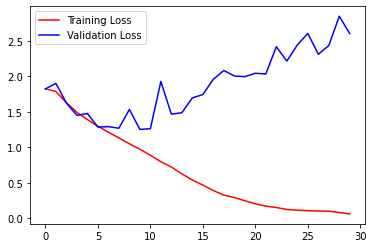

In [ ]:
def loss_plot(history):
  plt.plot(history.history["loss"],'r', label="Training Loss")
  plt.plot(history.history["val_loss"],'b', label="Validation Loss")
  plt.legend()

loss_plot(history)

#Observation

Seems like the model is getting overfitted by the data and the same arch. is not giving better results after tuning.
More steps that can be taken to improve the performance
1. Adding regularization in the model Arch.
2. Adding more data in validation set
3. Try with diff cnn arch

#Model Saving

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)
# model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


#Deploying model using OpenCV
<hr>

Note: Run the below code in your local machine

##loading model arch and weights

In [ ]:
model = model_from_json(open("model.json", "r").read())
model.load_weights('best_model.h5')
face_haar_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

##Open CV code for webcam and prediction

In [ ]:
from google.colab import files
uploaded = files.upload()   # Upload your image

Saving WhatsApp Image 2025-08-17 at 10.02.14 PM.jpeg to WhatsApp Image 2025-08-17 at 10.02.14 PM.jpeg


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from matplotlib import pyplot as plt

# load your haarcascade
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# pick the uploaded image filename
image_path = list(uploaded.keys())[0]

# read the uploaded image
test_image = cv2.imread(image_path)
gray_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

In [ ]:
faces_detected = face_haar_cascade.detectMultiScale(gray_image, 1.3, 5)

for (x, y, w, h) in faces_detected:
    cv2.rectangle(test_image, (x, y), (x+w, y+h), (255, 0, 0), 2)

    roi_gray = gray_image[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48, 48))
    image_pixels = img_to_array(roi_gray)
    image_pixels = np.expand_dims(image_pixels, axis=0)
    # image_pixels /= 255.0

    predictions = model.predict(image_pixels)
    max_index = np.argmax(predictions[0])

    emotion_detection = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    emotion_prediction = emotion_detection[max_index]

    cv2.putText(test_image, emotion_prediction, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Convert BGR (cv2) image to RGB for matplotlib
test_image_rgb = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10,7))
plt.imshow(test_image_rgb)
plt.axis("off")
plt.show()